<a href="https://colab.research.google.com/github/patriciaanggraeni/Machine_Learning_Ganjil_2023/blob/main/week_10_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import os
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

tfds.disable_progress_bar()

# Praktikum 1 - RNN untuk Analisis Sentimen

In [6]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [7]:
dataset, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [8]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


In [9]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'Sarah Silverman is really the "flavor of the month" comic right now. Is she really worth all the hype? Yes and no. She is funny at times, sometimes hilariously so (her standup routine is actually quite interesting, though not always funny). Other times, you\'re feeling cheated by the media for overhyping yet another performer. She is one of those really cute comedians that men especially flock to, saying that they dig her intelligence and wit. But if you corner them, most men will admit that they just want to sleep with her, and that\'s why they watch her. She reminds me of why many men flocked to Margaret Cho and Janeane Garofalo, even though neither of them are really "hot" now in terms of popularity. Sarah doesn\'t drink or smoke (at least cigs), so she should be hot when she\'s 60, so her fans (especially the male ones) can rejoice.<br /><br />As for this show, it\'s very much like her comedy. When it works, it\'s hilarious. When it doesn\'t, it\'s full blown tedium and 

## Buat Teks Encoder

In [10]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

vocab = np.array(encoder.get_vocabulary())
vocab[:20]

encoded_example = encoder(example)[:3].numpy()
encoded_example

for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'Sarah Silverman is really the "flavor of the month" comic right now. Is she really worth all the hype? Yes and no. She is funny at times, sometimes hilariously so (her standup routine is actually quite interesting, though not always funny). Other times, you\'re feeling cheated by the media for overhyping yet another performer. She is one of those really cute comedians that men especially flock to, saying that they dig her intelligence and wit. But if you corner them, most men will admit that they just want to sleep with her, and that\'s why they watch her. She reminds me of why many men flocked to Margaret Cho and Janeane Garofalo, even though neither of them are really "hot" now in terms of popularity. Sarah doesn\'t drink or smoke (at least cigs), so she should be hot when she\'s 60, so her fans (especially the male ones) can rejoice.<br /><br />As for this show, it\'s very much like her comedy. When it works, it\'s hilarious. When it doesn\'t, it\'s full blown tedium an

## Buat Model

In [11]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [12]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 8s 8s/step
[0.00462598]


In [13]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 60ms/step
[0.00462598]


In [14]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

## Train Model

In [15]:
history = model.fit(train_dataset, epochs=10, validation_data=test_dataset, validation_steps=30)

Epoch 1/10
391/391 [==============================] - 51s 106ms/step - loss: 0.6348 - accuracy: 0.5804 - val_loss: 0.5520 - val_accuracy: 0.5406
Epoch 2/10
391/391 [==============================] - 27s 68ms/step - loss: 0.5197 - accuracy: 0.7273 - val_loss: 0.4534 - val_accuracy: 0.7797
Epoch 3/10
391/391 [==============================] - 25s 63ms/step - loss: 0.4038 - accuracy: 0.8196 - val_loss: 0.3883 - val_accuracy: 0.8245
Epoch 4/10
391/391 [==============================] - 26s 66ms/step - loss: 0.3629 - accuracy: 0.8419 - val_loss: 0.3699 - val_accuracy: 0.8401
Epoch 5/10
391/391 [==============================] - 25s 63ms/step - loss: 0.3382 - accuracy: 0.8538 - val_loss: 0.3454 - val_accuracy: 0.8438
Epoch 6/10
391/391 [==============================] - 24s 60ms/step - loss: 0.3266 - accuracy: 0.8583 - val_loss: 0.3452 - val_accuracy: 0.8401
Epoch 7/10
391/391 [==============================] - 26s 67ms/step - loss: 0.3162 - accuracy: 0.8655 - val_loss: 0.3319 - val_accuracy

In [16]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 12s 31ms/step - loss: 0.3188 - accuracy: 0.8592
Test Loss: 0.3187703490257263
Test Accuracy: 0.8592000007629395


(0.0, 0.6512596681714058)

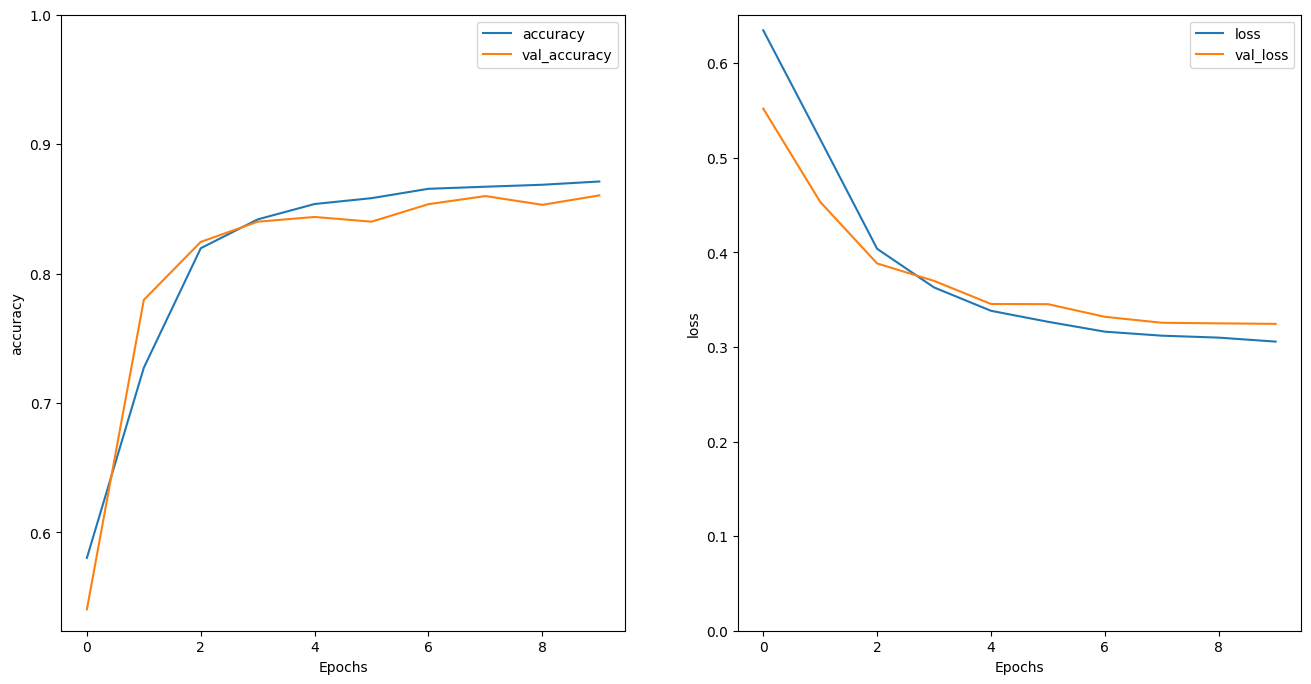

In [17]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [18]:
sample_text = ('The movie was cool. The animation and the graphics ' 'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

1/1 [==============================] - 4s 4s/step


## Stack two or more LSTM layers

In [19]:
model = tf.keras.Sequential([
  encoder,
  tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(1)
])

In [20]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
  optimizer=tf.keras.optimizers.Adam(1e-4),
  metrics=['accuracy'])

In [21]:
history = model.fit(train_dataset, epochs=10,
  validation_data=test_dataset,
  validation_steps=30)

Epoch 1/10
391/391 [==============================] - 79s 155ms/step - loss: 0.6059 - accuracy: 0.6034 - val_loss: 0.4106 - val_accuracy: 0.7969
Epoch 2/10
391/391 [==============================] - 47s 119ms/step - loss: 0.3710 - accuracy: 0.8330 - val_loss: 0.3447 - val_accuracy: 0.8432
Epoch 3/10
391/391 [==============================] - 46s 118ms/step - loss: 0.3330 - accuracy: 0.8554 - val_loss: 0.3323 - val_accuracy: 0.8542
Epoch 4/10
391/391 [==============================] - 47s 119ms/step - loss: 0.3189 - accuracy: 0.8626 - val_loss: 0.3431 - val_accuracy: 0.8583
Epoch 5/10
391/391 [==============================] - 47s 119ms/step - loss: 0.3151 - accuracy: 0.8650 - val_loss: 0.3300 - val_accuracy: 0.8625
Epoch 6/10
391/391 [==============================] - 46s 118ms/step - loss: 0.3065 - accuracy: 0.8690 - val_loss: 0.3319 - val_accuracy: 0.8443
Epoch 7/10
391/391 [==============================] - 47s 119ms/step - loss: 0.3057 - accuracy: 0.8694 - val_loss: 0.3274 - val_ac

In [22]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 19s 48ms/step - loss: 0.3251 - accuracy: 0.8634
Test Loss: 0.3251321613788605
Test Accuracy: 0.8634399771690369


In [23]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics ' 'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 7s 7s/step
[[-1.5445004]]


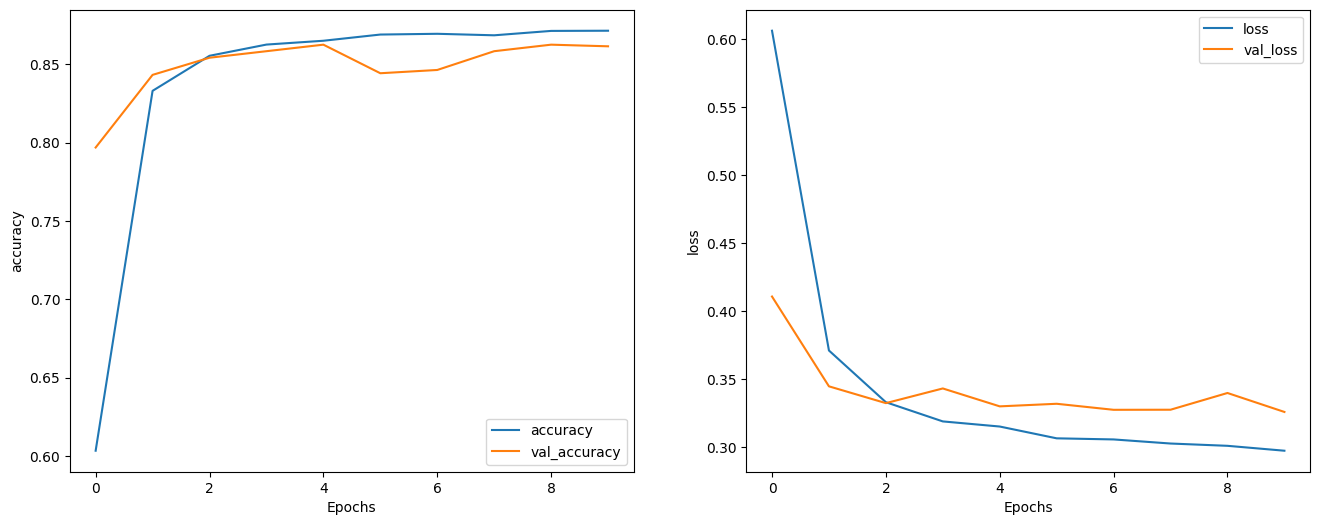

In [24]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

# Praktikum 2 - Generator Teks dengan RNN

## Setup

In [25]:
path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

1115394/1115394 [==============================] - 0s 0us/step


In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
# Read, then decode for py2 compat.
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
# length of text is the number of characters in it
print(f'Length of text: {len(text)} characters')

# Take a look at the first 250 characters in text
print(text[:250])

# The unique characters in the file
vocab = sorted(set(text))
print(f'{len(vocab)} unique characters')

Length of text: 1115394 characters
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

65 unique characters


## Olah Teks

### Vectorize Teks

In [28]:
example_texts = ['abcdefg', 'xyz']
chars = tf.strings.unicode_split(example_texts, input_encoding='UTF-8')
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

In [29]:
ids_from_chars = tf.keras.layers.StringLookup(
vocabulary=list(vocab), mask_token=None)

In [30]:
ids = ids_from_chars(chars)
ids

<tf.RaggedTensor [[40, 41, 42, 43, 44, 45, 46], [63, 64, 65]]>

In [31]:
chars_from_ids = tf.keras.layers.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

In [32]:
chars = chars_from_ids(ids)
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

In [33]:
tf.strings.reduce_join(chars, axis=-1).numpy()

array([b'abcdefg', b'xyz'], dtype=object)

In [34]:
def text_from_ids(ids):
    return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

### Membuat Trianing Set dan Target

In [35]:
all_ids = ids_from_chars(tf.strings.unicode_split(text, 'UTF-8'))
all_ids

<tf.Tensor: shape=(1115394,), dtype=int64, numpy=array([19, 48, 57, ..., 46,  9,  1])>

In [36]:
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

In [37]:
for ids in ids_dataset.take(10):
    print(chars_from_ids(ids).numpy().decode('utf-8'))

F
i
r
s
t
 
C
i
t
i


In [38]:
seq_length = 100

In [39]:
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)

for seq in sequences.take(1):
  print(chars_from_ids(seq))

tf.Tensor(
[b'F' b'i' b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':'
 b'\n' b'B' b'e' b'f' b'o' b'r' b'e' b' ' b'w' b'e' b' ' b'p' b'r' b'o'
 b'c' b'e' b'e' b'd' b' ' b'a' b'n' b'y' b' ' b'f' b'u' b'r' b't' b'h'
 b'e' b'r' b',' b' ' b'h' b'e' b'a' b'r' b' ' b'm' b'e' b' ' b's' b'p'
 b'e' b'a' b'k' b'.' b'\n' b'\n' b'A' b'l' b'l' b':' b'\n' b'S' b'p' b'e'
 b'a' b'k' b',' b' ' b's' b'p' b'e' b'a' b'k' b'.' b'\n' b'\n' b'F' b'i'
 b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':' b'\n' b'Y'
 b'o' b'u' b' '], shape=(101,), dtype=string)


In [40]:
for seq in sequences.take(5):
    print(text_from_ids(seq).numpy())

b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
b'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k'
b"now Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us ki"
b"ll him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be d"
b'one: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citi'


In [41]:
def split_input_target(sequence):
  input_text = sequence[:-1]
  target_text = sequence[1:]
  return input_text, target_text

split_input_target(list("Tensorflow"))
dataset = sequences.map(split_input_target)

for input_example, target_example in dataset.take(1):
  print("Input :", text_from_ids(input_example).numpy())
  print("Target:", text_from_ids(target_example).numpy())

Input : b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
Target: b'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


### Membuat Batch Training

In [42]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.int64, name=None), TensorSpec(shape=(64, 100), dtype=tf.int64, name=None))>

## Buat Model

In [43]:
# Length of the vocabulary in StringLookup Layer
vocab_size = len(ids_from_chars.get_vocabulary())

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

In [44]:
class MyModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True,
                                   return_state=True)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.gru.get_initial_state(x)
    x, states = self.gru(x, initial_state=states, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else:
      return x

In [45]:
model = MyModel(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

## Uji Model

In [46]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 66) # (batch_size, sequence_length, vocab_size)


In [47]:
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     multiple                  16896     
                                                                 
 gru (GRU)                   multiple                  3938304   
                                                                 
 dense_4 (Dense)             multiple                  67650     
                                                                 
Total params: 4022850 (15.35 MB)
Trainable params: 4022850 (15.35 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [48]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()

sampled_indices

array([45, 21, 38, 27, 23, 25, 35, 57,  4, 33, 38, 33, 59, 25, 21, 20, 64,
       25, 31, 32, 37, 54, 36, 42,  9, 62, 21, 27, 43,  7, 29,  8,  4, 24,
       28, 48, 59,  5, 39,  2, 21, 21,  7, 57, 37, 62, 58,  5, 25, 23, 24,
       61, 61,  2, 42, 49, 58, 39, 64, 17, 36, 43,  8, 27, 36, 55, 19,  5,
       28, 44, 51,  2, 16, 56, 37, 61,  7,  2, 37, 55, 58, 55, 65,  9, 46,
       38, 18, 63, 30, 20, 19, 20, 43, 57, 56, 17, 41, 36, 48, 27])

In [49]:
print("Input:\n", text_from_ids(input_example_batch[0]).numpy())
print()
print("Next Char Predictions:\n", text_from_ids(sampled_indices).numpy())

Input:
 b"Henry the Fourth by conquest got the crown.\n\nYORK:\n'Twas by rebellion against his king.\n\nKING HENRY "

Next Char Predictions:
 b'fHYNJLVr$TYTtLHGyLRSXoWc.wHNd,P-$KOit&Z HH,rXws&LJKvv cjsZyDWd-NWpF&Oel CqXv, Xpspz.gYExQGFGdrqDbWiN'


## Train Model

### Tambahan optimizer dan fungsi loss

In [50]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

In [51]:
example_batch_mean_loss = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("Mean loss:        ", example_batch_mean_loss)

Prediction shape:  (64, 100, 66)  # (batch_size, sequence_length, vocab_size)
Mean loss:         tf.Tensor(4.1908283, shape=(), dtype=float32)


In [52]:
tf.exp(example_batch_mean_loss).numpy()

66.0775

In [53]:
model.compile(optimizer='adam', loss=loss)

### Konfigurasi Checkpoints

In [54]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'

# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

### Lakukan Proses Training

In [55]:
EPOCHS = 20
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/20
172/172 [==============================] - 15s 65ms/step - loss: 2.7267
Epoch 2/20
172/172 [==============================] - 12s 61ms/step - loss: 1.9922
Epoch 3/20
172/172 [==============================] - 12s 62ms/step - loss: 1.7122
Epoch 4/20
172/172 [==============================] - 13s 61ms/step - loss: 1.5496
Epoch 5/20
172/172 [==============================] - 12s 59ms/step - loss: 1.4493
Epoch 6/20
172/172 [==============================] - 12s 61ms/step - loss: 1.3824
Epoch 7/20
172/172 [==============================] - 12s 61ms/step - loss: 1.3299
Epoch 8/20
172/172 [==============================] - 12s 61ms/step - loss: 1.2846
Epoch 9/20
172/172 [==============================] - 12s 61ms/step - loss: 1.2437
Epoch 10/20
172/172 [==============================] - 12s 61ms/step - loss: 1.2037
Epoch 11/20
172/172 [==============================] - 12s 62ms/step - loss: 1.1636
Epoch 12/20
172/172 [==============================] - 13s 61ms/step - loss: 1.1213
E

## Generate Teks

In [56]:
class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
    super().__init__()
    self.temperature = temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    # Create a mask to prevent "[UNK]" from being generated.
    skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index.
        values=[-float('inf')]*len(skip_ids),
        indices=skip_ids,
        # Match the shape to the vocabulary
        dense_shape=[len(ids_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, states=None):
    # Convert strings to token IDs.
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits]
    predicted_logits, states = self.model(inputs=input_ids, states=states,
                                          return_state=True)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    # Apply the prediction mask: prevent "[UNK]" from being generated.
    predicted_logits = predicted_logits + self.prediction_mask

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to characters
    predicted_chars = self.chars_from_ids(predicted_ids)

    # Return the characters and model state.
    return predicted_chars, states

In [57]:
one_step_model = OneStep(model, chars_from_ids, ids_from_chars)

In [58]:
start = time.time()
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)

ROMEO:
Then marry water, his conscenerate corn!
This was my nailst thing; and so formil;
But then, my son's regar before heaven should be
content.

ROMEO:
Then this is a Caltain lives. Down with the
swear-strange not with the storms of Rome, I had been down,
And be in many hours by calaming to
his reposed. Be that am not
Laugh'd thy all as a looker on.

ESCALUS:
He had serves i' Short, and have no blood at Pomfret,
Dost thou tell me thy chastisame nor garland:
Had I by the love I being born about thy fool,
hies sick, those thy faults were chrispend of night
Shall write and take on very dridged happiness.

ROMEO:
Sir, to go about to testimon.
Come, go with me, and if I wear by this.

Third Watchman:
O thinking-swey you to this preserving
should be dissequeit to your own.

KING HENRY VI:
Are Loidnoons are slain my shadew and thunderfully.
It is the least. How soon I see the heart by joint
And set their yielding of his native service: the
singeroo lecter: take not only nor means:
Though i

In [59]:
start = time.time()
states = None
next_char = tf.constant(['ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result, '\n\n' + '_'*80)
print('\nRun time:', end - start)

tf.Tensor(
[b"ROMEO:\nGood mortal men, you not remain,\nBut, such as e'er was bet us to claim upon't\nWhat is not ignorant: if beasts so longly token!\n\nKING HENRY VI:\nHad I behively in a world of myself?\n\nDUCHESS Kate, 'twas nothing to too heaven; and hast thou old the\nbutterly; thou'rt it possible,\nTo sink it is to known the younger free dishonour:\nPretty inheritance, heaven merisure,\nShall watch your brother by thain earth.\n\nClown:\nI am glar he's come to know a word.\n\nCAPULET:\nNo, not a word: he has holpide to besiegh at mine.\n\nMIRANDA:\nLet them gold in fear.\n3 KING HENRY VI\n\nGLOUCESTER:\nNear me not, by your own; you know not where;\nThere is my head born boy.\nOf what my father, Prince Florizel,\nSole jount to let him joy!\nWe do laid in you, only so often it meduband,\nWhen guessly abtory to speed it in\nthe happy man? Between thyself and will\nThis feat cried 'montaginging thou didst prove more length.\n\nHENRY BOLINGBROKE:\nNay, tradities and my morrows name

## Ekspor Model Generator

In [60]:
tf.saved_model.save(one_step_model, 'one_step')
one_step_reloaded = tf.saved_model.load('one_step')

In [61]:
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(100):
  next_char, states = one_step_reloaded.generate_one_step(next_char, states=states)
  result.append(next_char)

print(tf.strings.join(result)[0].numpy().decode("utf-8"))

ROMEO:
Let that barron like most swallow with these crides
To try harm muster on the key.

EXETER:
And Sti


# Tugas

In [62]:
# mendefinisikan kelas CustomTraining yang merupakan turunan dari model MyModel.
class CustomTraining(MyModel):
   # mengompilasi metode train_step menjadi sebuah graph TensorFlow, meningkatkan kinerja dan efisiensi dalam pelatihan model.
  @tf.function
  # melatih model selama satu langkah pelatihan.
  # Metode ini menerima input dalam bentuk pasangan (inputs, labels).
  def train_step(self, inputs):
   # mendekomposisi input menjadi inputs dan labels, yang mengandung data input dan label yang sesuai
      inputs, labels = inputs
      # menggunakan tf.GradientTape untuk melacak perhitungan dalam metode ini untuk menghitung gradien loss terhadap parameter-model.
      with tf.GradientTape() as tape:
         # menghitung prediksi model dengan memanggil metode self(inputs, training=True).
         predictions = self(inputs, training=True)
         # menghitung loss model dengan memanggil metode self.loss dengan labels dan predictions sebagai argumen.
         loss = self.loss(labels, predictions)
      # menghitung gradien loss terhadap parameter-model dengan menggunakan tape yang telah DIbuat sebelumnya.
      grads = tape.gradient(loss, model.trainable_variables)
      # menerapkan gradien ke parameter-model menggunakan optimizer yang telah DIkonfigurasikan sebelumnya.
      self.optimizer.apply_gradients(zip(grads, model.trainable_variables))
      # mengembalikan dictionary yang berisi loss sebagai metrik yang dapat digunakan untuk memantau performa pelatihan.
      return {'loss': loss}

In [63]:
# Model ini akan digunakan untuk pelatihan dengan logika pelatihan yang telah DIdefinisikan dalam metode train_step yang khusus.
model = CustomTraining(
    vocab_size=len(ids_from_chars.get_vocabulary()),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

In [64]:
# mengonfigurasi model untuk pelatihan dengan menggunakan optimizer Adam dan loss function Sparse Categorical Crossentropy.
model.compile(optimizer = tf.keras.optimizers.Adam(),
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))

In [65]:
# memanggil metode fit pada model Anda untuk melatih model dengan dataset yang DIberikan selama 1 epoch.
model.fit(dataset, epochs=1)

172/172 [==============================] - 16s 61ms/step - loss: 2.6892


In [66]:
EPOCHS = 10

# digunakan untuk menghitung rata-rata loss selama pelatihan.
mean = tf.metrics.Mean()

# melakukan loop sebanyak EPOCHS (dalam hal ini, 10 epoch).
for epoch in range(EPOCHS):
    start = time.time()

    # mengatur ulang state rata-rata loss dengan mean.reset_states().
    mean.reset_states()
    # memanggil model.train_step([inp, target]) untuk melatih model dengan satu batch data.
    # mengupdate rata-rata loss dengan memanggil mean.update_state(logs['loss']).
    for (batch_n, (inp, target)) in enumerate(dataset):
        logs = model.train_step([inp, target])
        mean.update_state(logs['loss'])

        # setiap 50 batch, mencetak informasi seperti nomor epoch, nomor batch, dan loss batch yang dihitung
        if batch_n % 50 == 0:
            template = f"Epoch {epoch+1} Batch {batch_n} Loss {logs['loss']:.4f}"
            print(template)

    # saving (checkpoint) the model every 5 epochs
    if (epoch + 1) % 5 == 0:
       model.save_weights(checkpoint_prefix.format(epoch=epoch))

    # mencetak rata-rata loss selama epoch tersebut, waktu yang diperlukan untuk satu epoch, dan garis pembatas.
    print()
    print(f'Epoch {epoch+1} Loss: {mean.result().numpy():.4f}')
    print(f'Time taken for 1 epoch {time.time() - start:.2f} sec')
    print("_"*80)

Epoch 1 Batch 0 Loss 2.1757
Epoch 1 Batch 50 Loss 2.0299
Epoch 1 Batch 100 Loss 1.9111
Epoch 1 Batch 150 Loss 1.8557

Epoch 1 Loss: 1.9710
Time taken for 1 epoch 13.80 sec
________________________________________________________________________________
Epoch 2 Batch 0 Loss 1.8338
Epoch 2 Batch 50 Loss 1.7413
Epoch 2 Batch 100 Loss 1.6672
Epoch 2 Batch 150 Loss 1.6271

Epoch 2 Loss: 1.6956
Time taken for 1 epoch 12.06 sec
________________________________________________________________________________
Epoch 3 Batch 0 Loss 1.6014
Epoch 3 Batch 50 Loss 1.5459
Epoch 3 Batch 100 Loss 1.5045
Epoch 3 Batch 150 Loss 1.4966

Epoch 3 Loss: 1.5370
Time taken for 1 epoch 20.47 sec
________________________________________________________________________________
Epoch 4 Batch 0 Loss 1.4925
Epoch 4 Batch 50 Loss 1.4956
Epoch 4 Batch 100 Loss 1.3857
Epoch 4 Batch 150 Loss 1.4054

Epoch 4 Loss: 1.4414
Time taken for 1 epoch 11.45 sec
_____________________________________________________________________

## Perbedaan Dengan Praktikum 2

Kode yang digunakan menggunakan model TensorFlow, terutama dalam menghasilkan teks yang mirip dengan tulisan Shakespeare. Kode ini memeiliki beberapa perbedaan dengan praktikum 2

Model yang digunakan: pada praktikum menggunakan model MyModel dimana model
Bahasa rekrusif sederhana dengan satu lapisan GRU, sedangkan model tugas menggunakan kelas CustomTraining yang menurunkan MyModel dimana menentukan langkah pelatihan kustom dengan penggunaan tf.function.

Proses Pelatihan: pada praktikum melatih model mengunakan 20 epoch dengan mengukur
loss dan menyimpan control pada titik-titik tertentu, sedangkan pada tugas hanta melatih model menggunakan 1 epoch untuk tujuan demontrasi dan menggunakan tf.metrics.Mean() untuk menghitung rata-rata loss selama pelatihan.

Penyimpanan Model: pada praktikum menggunakan tf.keras.callbacks.ModelCheckpoint
berguna untuk menyimpan berat pada titik-titik tertentu selama pelatihan, tetapi pada tugas tidak ada langkah penyimpanan model yang ditunjukkan setelah 1 epoch pelatihan.

Generasi Teks: pada praktikum tidak ada generasi teks yang ditunjukkan, tetapi didalam tugas
menggunakan model yang sudah dilatih untuk menghasilkan teks yang mirip dengan tulisan Shakespeare.

Jadi, perbedaan utama antara kedua kdoe tersebut adalah pada proses pelatihan dan penggunaan model, dimana praktikum lebih fokus pada pelatihan model Bahasa, sementara tugas lebih fokus pada penggunaan model yang sudah dilatih untuk menghasilkan teks yang serupa dengan Shakespeare.